In [77]:
import mpmath
import numpy
import numpy as np
import pandas as pd
import seaborn as sb
import networkx as nx
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt

def format_edges(weight):
    if weight<0.03:
        return ""
    else:
        return f"{weight:.3f}"


3.413028512805852


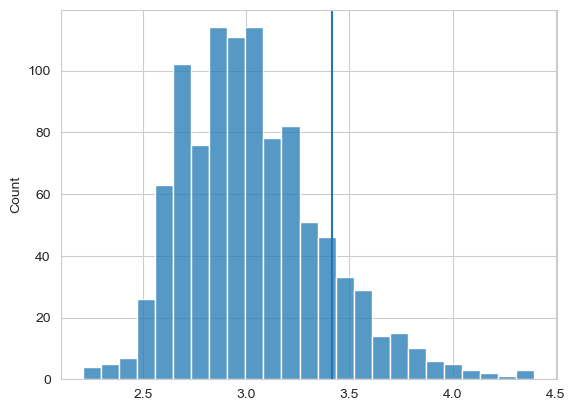

In [2]:
## Assuming binary dataset with sensitivity d log n / n

d = 20 # num dims
p = 0.01 # zCDP
n = 1000 # num samples
mu  = 0.0001
# 0.1 bound
# probabilty to stay outside the bound of a max error.
## With probability 1 - m, error is not larger as the bound
numDS = 1000
values = np.random.normal(0, (d**2 * np.log(n)**2) / (2 * p * n**2), size=(numDS, d*d))
a = [max(abs(x), key=abs) for x in values] # max error

# printing max error per round

plt = sb.histplot(a)
sigma = (d * np.log(n) / n / np.sqrt(2 * p))
threshold =  (sigma) * np.sqrt(np.log(d / mu))
print(threshold)

plt.axvline(x = threshold,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1) # Top of the plot
#plt.axvline(x = -threshold,    # Line on x = 2
#            ymin = 0, # Bottom of the plot
#            ymax = 1) # Top of the plot


In [98]:
# Load Data
columns = [3,6,7,8,9,10,11,17,24]
dataset=pd.read_csv("./datasets/Surgical-deepnet.csv", header=0, usecols=columns, index_col=0)
d = len(columns)
n = len(dataset)

dataset = dataset.reset_index()
keys = {c: i for i, c in enumerate(dataset.columns)}
dataset = dataset.to_numpy()

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def calculate_MI_matrix(ds):
    n = dataset.shape[1]
    mutualInformation = np.zeros((n, n))
    for ix in np.arange(n):
        for jx in np.arange(n):
            mutualInformation[ix,jx]= calc_MI(dataset[:, ix], dataset[:, jx], 10)
    return mutualInformation

MST on Real Graph 0.20138706906229925


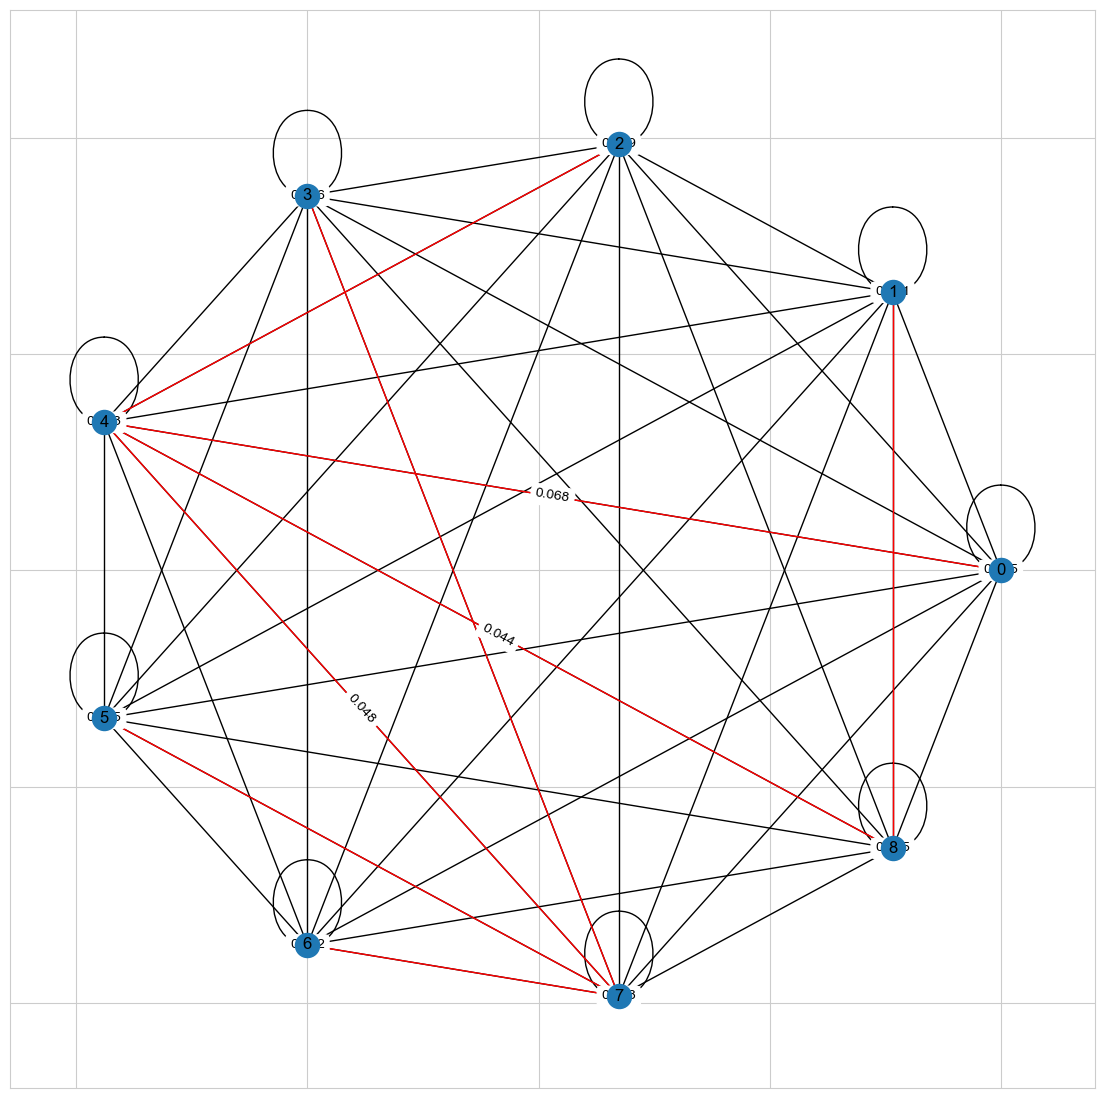

In [115]:
## Step 1: real MST

mutualInformation = calculate_MI_matrix(dataset)
G = nx.from_numpy_array(mutualInformation)
G = nx.convert_node_labels_to_integers(G)
T= nx.maximum_spanning_tree(G, algorithm ='prim')

# Calculating the Real weight
weight = 0
for _,_,d in T.edges(data=True):
    weight += d['weight']
print(f'MST on Real Graph {weight}')

plt.figure(3,figsize=(14,14))
pos = nx.circular_layout(G, scale=40)  # positions for all nodes - seed for reproducibility

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edges(T, pos, edge_color="red")
nx.draw_networkx_labels(G, pos)
# edge weight labels
edge_labels = dict([((u,v,), format_edges(d['weight'])) for u,v,d in G.edges(data=True)])

nx.draw_networkx_edge_labels(G, pos, edge_labels)
# larger figure size
plt.show()

We have 14635 samples on 9 dimensions
MST on Real Graph 0.20138706906229925
MST on Fake Graph 0.21134548868939015


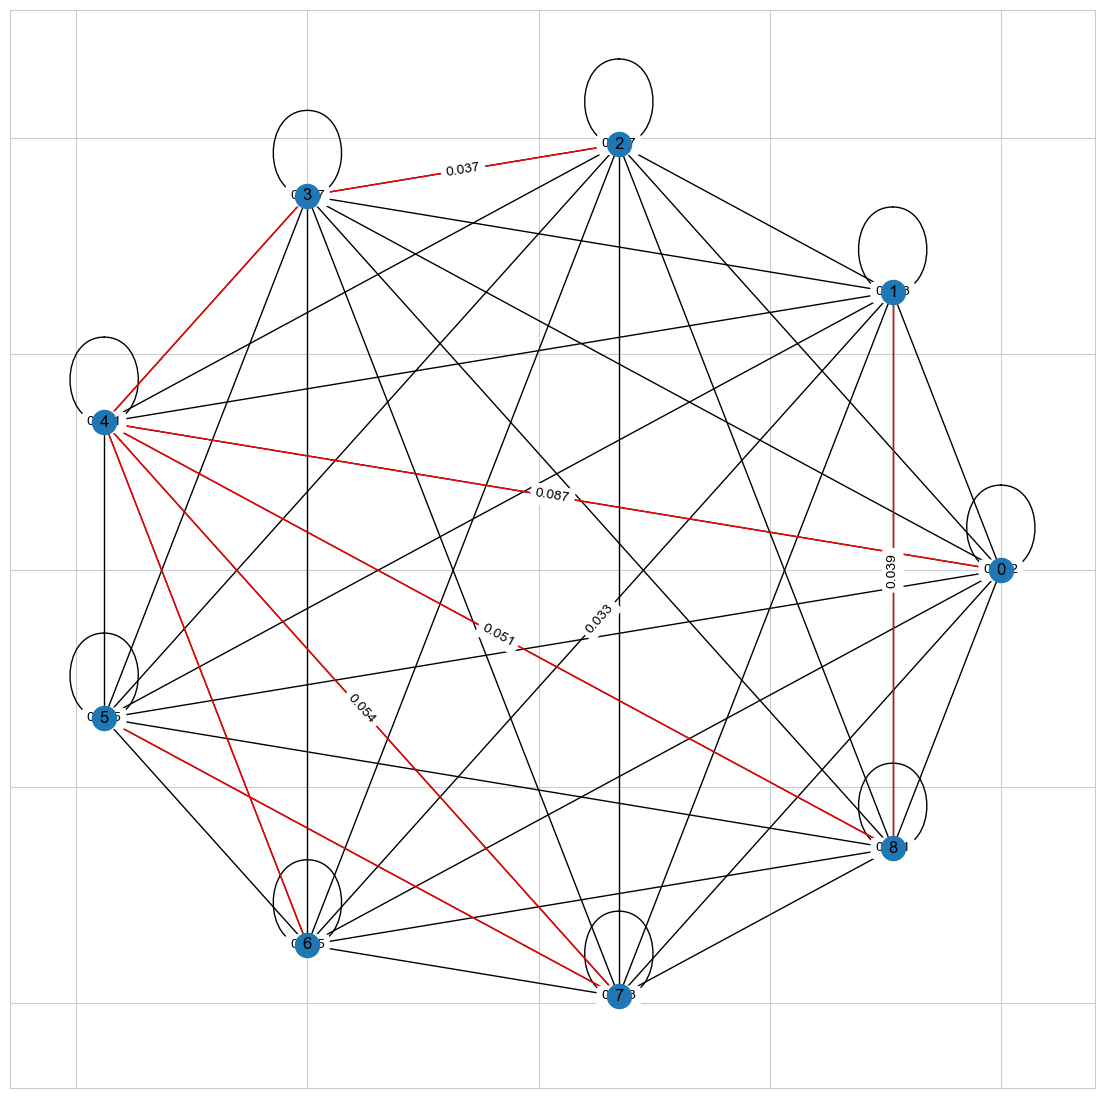

In [201]:
# Step 2: Noisy MST
def private_mst(p, d, dataset, priv=True):
    # Calcs MI Matrix
    mutualInformation = calculate_MI_matrix(dataset)
    # Adds noise 
    if priv:
        cov = np.zeros(shape=(d,d))
        np.fill_diagonal(cov, (np.log(n) * d / n ) ** 2 / 2 / p)
        N = (np.random.multivariate_normal(np.zeros(shape=d), cov, size = d))
        mutualInformation+=N
    G = nx.from_numpy_array(mutualInformation)
    T = nx.maximum_spanning_tree(G, algorithm='prim')
    
    # Calc weight, TODO replace with Lambda
    mst_weight = 0
    for _,_,d in T.edges(data=True):
        mst_weight += d['weight']
    return T, mst_weight
    
p = 1 # privacy rho
d = len(columns)

(T1, private_weight) = private_mst(p, d, dataset)
(T2, real_weight) = private_mst(p, d, dataset, priv=False)
G = nx.convert_node_labels_to_integers(G)

# Calculating the Real weight
print(f'We have {n} samples on {d} dimensions')
print(f'MST on Real Graph {real_weight}')
print(f'MST on Fake Graph {private_weight}')

plt.figure(3,figsize=(14,14))
pos = nx.circular_layout(G, scale=40)  # positions for all nodes - seed for reproducibility

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edges(T1, pos, edge_color="red")
nx.draw_networkx_labels(G, pos)
# edge weight labels
edge_labels = dict([((u,v,), format_edges(d['weight'])) for u,v,d in G.edges(data=True)])

nx.draw_networkx_edge_labels(G, pos, edge_labels)
# larger figure size
plt.show()

In [199]:
df = pd.DataFrame()
(T2, real_weight) = private_mst(0, d, dataset, priv=False)
for p in np.arange(0.0001,0.5, 0.0001):
    (T1, private_weight) = private_mst(p, d, dataset)
    row = {
        "p": p,
        "priv-gauss-noise": private_weight, 
        "real": real_weight}
    df = df.append(row, ignore_index=True)
print(df)


/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_96083/3016686508.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_96083/3016686508.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_96083/3016686508.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_96083/3016686508.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(

           p  priv-gauss-noise      real
0     0.0001          4.251896  0.201387
1     0.0002          3.362581  0.201387
2     0.0003          2.866182  0.201387
3     0.0004          2.605088  0.201387
4     0.0005          2.224326  0.201387
...      ...               ...       ...
4994  0.4995          0.228684  0.201387
4995  0.4996          0.223477  0.201387
4996  0.4997          0.222427  0.201387
4997  0.4998          0.234190  0.201387
4998  0.4999          0.217290  0.201387

[4999 rows x 3 columns]


/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_96083/3016686508.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_96083/3016686508.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


<Axes: xlabel='p', ylabel='value'>

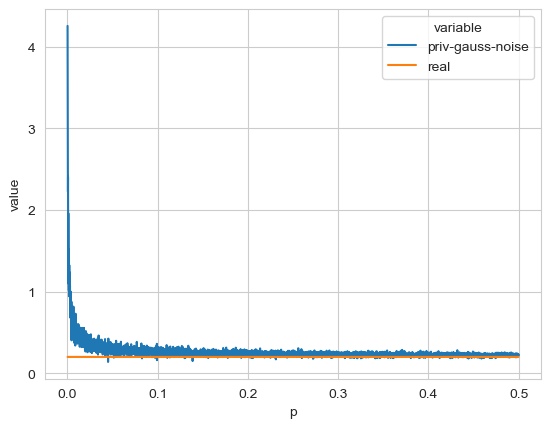

In [202]:
sb.lineplot(x='p', y='value', hue='variable',
             data=pd.melt(df, ['p']))